# Understanding redrock output

This tutorial describes how to combine the zbest fit coefficients with the
redrock templates to see how the best fit template compares to the actual data.

It uses the "dc17a-lite" subset available at NERSC in
```
/project/projectdirs/desi/datachallenge/dc17a-twopct/dc17a-lite.tar.gz
```
See https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop/JuneMeeting for instructions on installing the DESI code. The bottom of this tutorial lists the code versions used while testing this.

Stephen Bailey<br/>
June 2017

## Basic setup

In [1]:
import os
from astropy.table import Table
import numpy as np
import desispec.io
import redrock.io
%pylab inline

Populating the interactive namespace from numpy and matplotlib


For convenience, move into the directory where you unpacked the `dc17a-lite.tar.gz` file
and set some environment variables so that desispec can find the files.

In [2]:
os.chdir('/data/desi/datachallenge/dc17a-lite')
os.environ['DESI_SPECTRO_REDUX'] = os.path.join(os.getcwd(), 'spectro/redux')
os.environ['SPECPROD'] = 'dc17a2'

## Read in some spectra and the matching zbest file

In [3]:
specfile = desispec.io.findfile('spectra', groupname='17244', nside=64)
zbestfile = desispec.io.findfile('zbest', groupname='17244', nside=64)

spectra = desispec.io.read_spectra(specfile)
zbest = Table.read(zbestfile)

What did we get?

In [4]:
zbest['SPECTYPE', 'Z'][0:5]

SPECTYPE,Z
str6,float64
GALAXY,0.811711629784
GALAXY,0.967788478164
QSO,1.27921863362
GALAXY,0.347500698115
GALAXY,1.04971884746


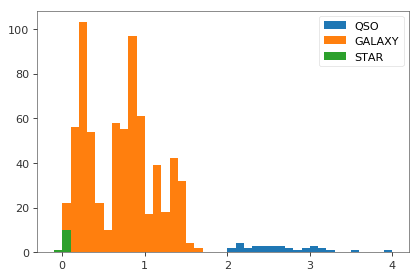

In [5]:
for spectype in set(zbest['SPECTYPE']):
    ii = (zbest['SPECTYPE'] == spectype)
    hist(zbest['Z'][ii], 41, (-0.1,4), label=spectype.strip())
legend()

Note that redrock does not distinguish between ELGs and LRGs: both are just spectype=='GALAXY'.

## Compare redrock templates to spectra

`redrock.io.read_templates` returns a list of templates, then convert those into a dict of template type -> Template object.

In [6]:
tx = redrock.io.read_templates()
for t in tx.values():
    print('{} {} has {} PCA eigenvectors'.format(t.type, t.subtype, t.flux.shape[0]))

GALAXY  has 10 PCA eigenvectors
QSO  has 4 PCA eigenvectors
STAR A has 5 PCA eigenvectors
STAR B has 5 PCA eigenvectors
STAR F has 5 PCA eigenvectors
STAR G has 5 PCA eigenvectors
STAR K has 5 PCA eigenvectors
STAR M has 5 PCA eigenvectors


Pick a target and use its zbest coefficients to construct the redrock template fit for that
object.

In [7]:
i = 0
z = zbest['Z'][i]
targetid = zbest['TARGETID'][i]
spectype = zbest['SPECTYPE'][i].strip()
ncoeff = tx[spectype].flux.shape[0]
coeff = zbest['COEFF'][i][0:ncoeff]

In [8]:
tflux = tx[spectype].flux.T.dot(coeff)
twave = tx[spectype].wave * (1+z)

(-1, 2)

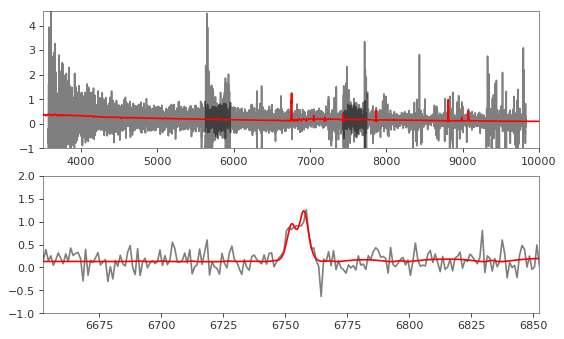

In [9]:
ispec = np.where(spectra.fibermap['TARGETID'] == targetid)[0][0]

figure(figsize=(8,5))
subplot(211)
maxflux = 0.0
for band in spectra.bands:
    plot(spectra.wave[band], spectra.flux[band][ispec], 'k-', alpha=0.5)
    maxflux = max(maxflux, np.max(spectra.flux[band][ispec]))

plot(twave, tflux, 'r-')
xlim(3500, 10000)
ylim(-1, 0.9*maxflux)

#- zoom in on [OII]
subplot(212)
for band in spectra.bands:
    plot(spectra.wave[band], spectra.flux[band][ispec], 'k-', alpha=0.5)

plot(twave, tflux, 'r-')
xlim(3727*(1+z)-100, 3727*(1+z)+100)
ylim(-1,2)

That wasn't quite correct because the redrock templates are high resolution
before any instrumental resolution is applied.  Let's update that to include
the spectral resolution.

In [10]:
from desispec.interpolation import resample_flux
from desispec.resolution import Resolution
R = Resolution(spectra.resolution_data['r'][i])
txflux = R.dot(resample_flux(spectra.wave['r'], twave, tflux))

(6652.2492442067887, 6852.2492442067887)

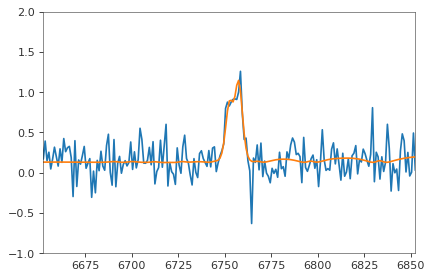

In [11]:
plot(spectra.wave['r'], spectra.flux['r'][ispec])
plot(spectra.wave['r'], txflux)
ylim(-1,2)
xlim(3727*(1+z)-100, 3727*(1+z)+100)

## Future work

**TODO**: document redrock rr*.h5 files, e.g. the chi2 vs. redshift and how to get the second, third, etc. best fits

## Code versions

This step requires you to have added `tutorials` to your `$PYTHONPATH` prior to launching jupyter, e.g.
```
export PYTHONPATH=$(pwd):$PYTHONPATH
jupyter notebook redrock/RedrockOutput.ipynb
```

In [13]:
import desitutorials
print('Code versions used for this tutorial:')
desitutorials.print_code_versions()

Code versions used for this tutorial:
python      : 3.5.2
numpy       : 1.11.2
scipy       : 0.18.1
astropy     : 1.2.1
yaml        : 3.12
matplotlib  : 2.0.0
desiutil    : 1.9.6.dev526
desispec    : 0.15.2.dev1569
redrock     : 0.4.1.dev1
speclite    : 0.5
